In [26]:
!pip install fredapi > /dev/null

This product uses the FRED® API but is not endorsed or certified by the Federal Reserve Bank of St. Louis

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("fred_key")

## 1. Create The Fred Object

In [28]:
fred = Fred(api_key=secret_value_0)

## 2. Search for economic data

In [29]:
sp_search = fred.search('S&P', order_by='popularity')

--Review Search Results

In [30]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-01-09,2024-01-09,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-01-08,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-01-09 09:06:02-06:00,93,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-01-09,2024-01-09,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2023-10-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-12-26 08:12:02-06:00,88,"For more information regarding the index, plea..."
MEHOINUSA672N,MEHOINUSA672N,2024-01-09,2024-01-09,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
SP500,SP500,2024-01-09,2024-01-09,S&P 500,2014-01-09,2024-01-08,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-01-08 19:10:58-06:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-01-09,2024-01-09,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-01-08,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-01-09 09:06:05-06:00,82,This data represents the effective yield of th...


## 3. Pull Raw Data & Plot

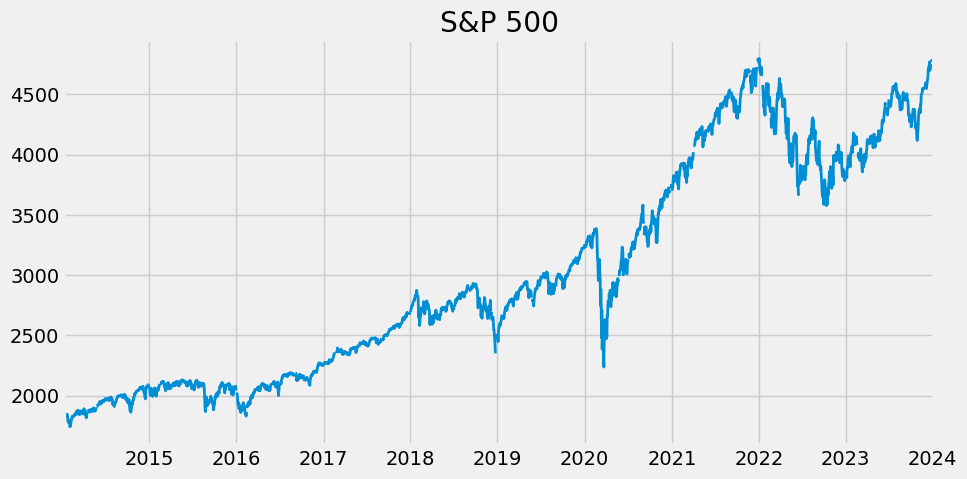

In [31]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

## 4. Pull and Join Multiple Data Series

In [32]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]
unemp_df = unemp_df.loc[(unemp_df.index.str.len() == 4) | (unemp_df.index == 'UNRATE')] 

--Make sure we have only states (plus DC and overall)

In [33]:
unemp_df.shape

(52, 15)

## 4a) Unemployment

-- Clean title to include only state name

In [34]:
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()

all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
uemp_states = pd.concat(all_results, axis=1)

--ID to column headdings

In [35]:
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

--Print

In [36]:
uemp_states

,California,Texas,New York,Florida,Ohio,Illinois,Michigan,Pennsylvania,Alabama,New Jersey,...,Wyoming,Utah,Montana,Puerto Rico,Maine,the District of Columbia,Delaware,South Dakota,Rhode Island,Vermont
1976-01-01,9.2,5.8,10.3,9.7,8.1,6.6,9.9,8.0,6.6,10.3,...,4.1,5.8,5.8,19.6,8.7,8.7,8.0,3.3,7.8,8.6
1976-02-01,9.2,5.8,10.3,9.7,8.1,6.6,9.9,8.1,6.6,10.3,...,4.1,5.9,5.8,19.5,8.7,8.7,8.0,3.3,7.8,8.6
1976-03-01,9.1,5.9,10.2,9.6,8.1,6.6,9.9,8.1,6.6,10.3,...,4.1,5.8,5.8,19.3,8.6,8.6,8.0,3.2,7.7,8.6
1976-04-01,9.1,5.9,10.2,9.5,8.0,6.6,9.8,8.1,6.5,10.3,...,4.0,5.8,5.8,19.0,8.6,8.5,8.1,3.1,7.7,8.6
1976-05-01,9.0,5.9,10.1,9.3,7.8,6.6,9.6,8.1,6.4,10.3,...,3.9,5.7,5.8,18.9,8.5,8.4,8.3,3.1,7.7,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,4.6,4.1,3.9,2.7,3.3,4.0,3.6,3.5,2.1,3.9,...,3.0,2.4,2.5,6.2,2.4,5.0,4.1,1.9,2.8,1.8
2023-08-01,4.6,4.1,3.9,2.7,3.4,4.1,3.7,3.5,2.1,4.2,...,2.9,2.5,2.5,6.2,2.5,5.0,4.1,1.9,2.7,1.8
2023-09-01,4.7,4.1,4.0,2.8,3.4,4.4,3.9,3.4,2.2,4.4,...,2.9,2.6,2.7,6.0,2.7,5.0,4.1,1.9,2.6,1.9
2023-10-01,4.8,4.1,4.2,2.8,3.6,4.6,4.1,3.4,2.3,4.6,...,2.9,2.7,2.8,5.8,2.8,5.0,4.2,2.0,2.7,2.0


--Plot

In [37]:
px.line(uemp_states)

--Unemployment rate bar

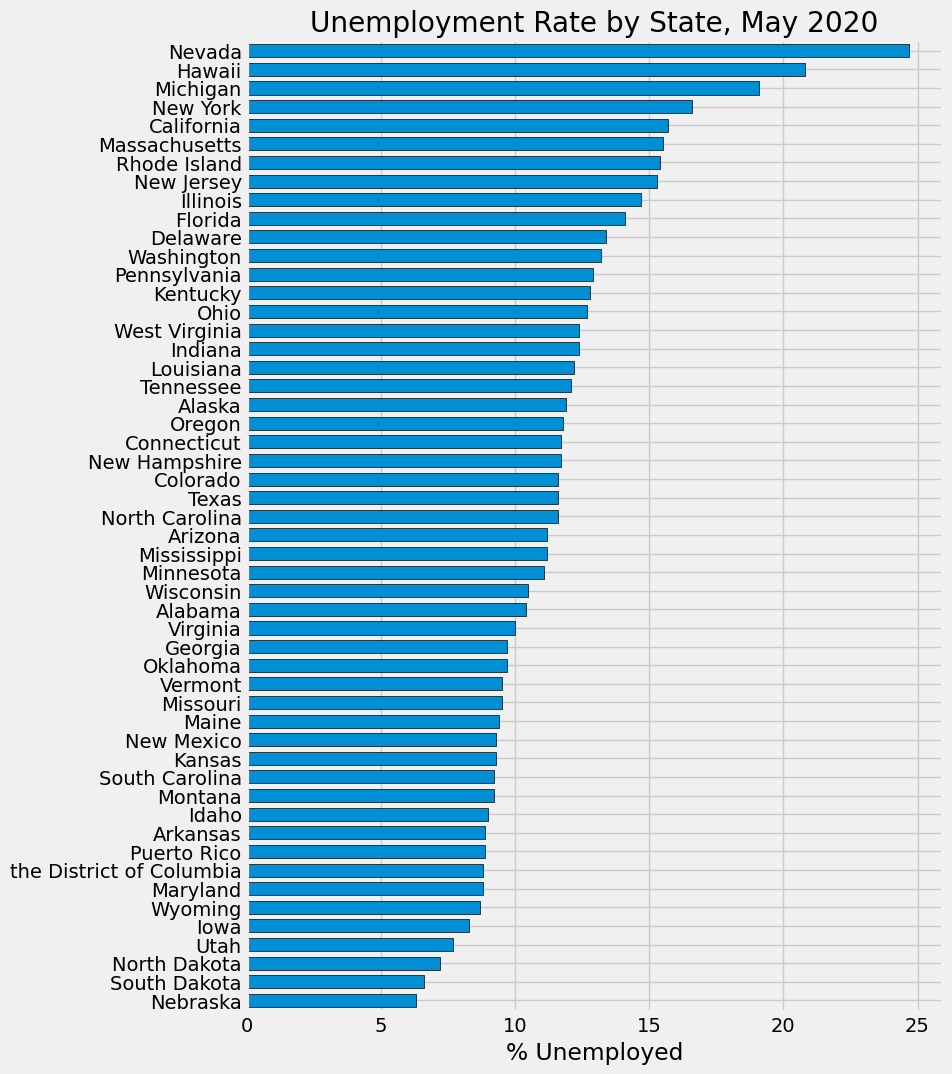

In [38]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

## 4b. Participation Rate

--Pull participation state info

In [39]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for')]
part_df = part_df.loc[(part_df.index.str.len() == 7) | (part_df.index == 'CIVPART')]

--Change pd. display settings 

In [40]:
pd.set_option('display.max_rows', 10)

--Check that states are accounted for

In [41]:
part_df.shape

(51, 15)

--Print 

In [42]:
part_df

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
LBSSA06,LBSSA06,2024-01-09,2024-01-09,Labor Force Participation Rate for California,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:16-06:00,12,A state's labor-force participation rate is th...
LBSSA01,LBSSA01,2024-01-09,2024-01-09,Labor Force Participation Rate for Alabama,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:15-06:00,9,A state's labor-force participation rate is th...
LBSSA21,LBSSA21,2024-01-09,2024-01-09,Labor Force Participation Rate for Kentucky,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:07-06:00,21,A state's labor-force participation rate is th...
LBSSA28,LBSSA28,2024-01-09,2024-01-09,Labor Force Participation Rate for Mississippi,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:13-06:00,19,A state's labor-force participation rate is th...
LBSSA27,LBSSA27,2024-01-09,2024-01-09,Labor Force Participation Rate for Minnesota,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:09-06:00,19,A state's labor-force participation rate is th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LBSSA20,LBSSA20,2024-01-09,2024-01-09,Labor Force Participation Rate for Kansas,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:18-06:00,3,A state's labor-force participation rate is th...
LBSSA10,LBSSA10,2024-01-09,2024-01-09,Labor Force Participation Rate for Delaware,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:39-06:00,2,A state's labor-force participation rate is th...
LBSSA46,LBSSA46,2024-01-09,2024-01-09,Labor Force Participation Rate for South Dakota,1976-01-01,2023-11-01,Monthly,M,Percent,%,Seasonally Adjusted,SA,2023-12-22 09:02:32-06:00,2,A state's labor-force participation rate is th...


In [43]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)

In [44]:
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [45]:
part_states

,California,Alabama,Kentucky,Mississippi,Minnesota,Michigan,Ohio,Florida,New York,Wisconsin,...,Nebraska,Missouri,Arkansas,Vermont,Rhode Island,Kansas,Delaware,South Dakota,Wyoming,District Of Columbia
1976-01-01,62.6,57.0,60.5,58.8,65.6,61.6,61.7,55.8,58.0,65.6,...,64.9,60.5,57.9,63.6,63.8,65.1,62.7,64.6,65.3,64.4
1976-02-01,62.4,56.9,60.3,58.6,65.5,61.5,61.7,55.7,58.0,65.5,...,64.9,60.3,57.8,63.4,63.7,65.0,62.5,64.4,64.9,64.5
1976-03-01,62.2,56.8,60.2,58.5,65.4,61.5,61.7,55.5,58.0,65.4,...,64.8,60.3,57.7,63.2,63.6,64.9,62.5,64.4,64.7,64.5
1976-04-01,62.2,56.8,60.1,58.5,65.4,61.6,61.6,55.5,58.0,65.4,...,64.8,60.4,57.7,63.5,63.7,65.0,62.4,64.3,64.9,64.5
1976-05-01,62.3,56.8,60.1,58.5,65.5,61.7,61.6,55.4,58.1,65.5,...,64.8,60.6,57.7,63.6,63.6,65.1,62.4,64.3,65.2,64.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,62.4,57.0,57.7,54.4,68.5,61.0,62.1,59.7,61.4,65.5,...,69.4,63.6,57.7,63.9,63.3,66.8,60.1,67.8,64.6,70.8
2023-08-01,62.4,57.0,57.6,54.3,68.5,61.3,62.1,59.7,61.5,65.7,...,69.2,63.7,57.7,64.0,63.3,66.7,60.3,67.8,64.5,70.9
2023-09-01,62.3,57.0,57.4,54.1,68.5,61.6,62.1,59.8,61.6,65.8,...,69.2,63.7,57.8,64.1,63.4,66.7,60.5,67.8,64.4,71.1
2023-10-01,62.3,57.0,57.3,53.9,68.5,61.8,62.0,59.8,61.6,65.8,...,69.1,63.6,57.8,64.2,63.5,66.7,60.6,67.8,64.2,71.4


## 5. Plot Unemployment vs Participation

In [46]:
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

In [47]:
print(uemp_states.columns)
print(part_states.columns)

Index(['California', 'Texas', 'New York', 'Florida', 'Ohio', 'Illinois',
       'Michigan', 'Pennsylvania', 'Alabama', 'New Jersey', 'Colorado',
       'Georgia', 'Kentucky', 'Massachusetts', 'Arizona', 'Minnesota',
       'Virginia', 'Wisconsin', 'North Carolina', 'Oregon', 'Tennessee',
       'Indiana', 'Maryland', 'Washington', 'Iowa', 'Nevada', 'Arkansas',
       'Missouri', 'South Carolina', 'Louisiana', 'West Virginia', 'Oklahoma',
       'New Mexico', 'Connecticut', 'Alaska', 'Hawaii', 'Mississippi',
       'Kansas', 'Idaho', 'New Hampshire', 'Nebraska', 'North Dakota',
       'Wyoming', 'Utah', 'Montana', 'Puerto Rico', 'Maine',
       'District Of Columbia', 'Delaware', 'South Dakota', 'Rhode Island',
       'Vermont'],
      dtype='object')
Index(['California', 'Alabama', 'Kentucky', 'Mississippi', 'Minnesota',
       'Michigan', 'Ohio', 'Florida', 'New York', 'Wisconsin', 'Massachusetts',
       'Texas', 'Tennessee', 'Maryland', 'Pennsylvania', 'Maine', 'Colorado',
       'G

-- Plot 1

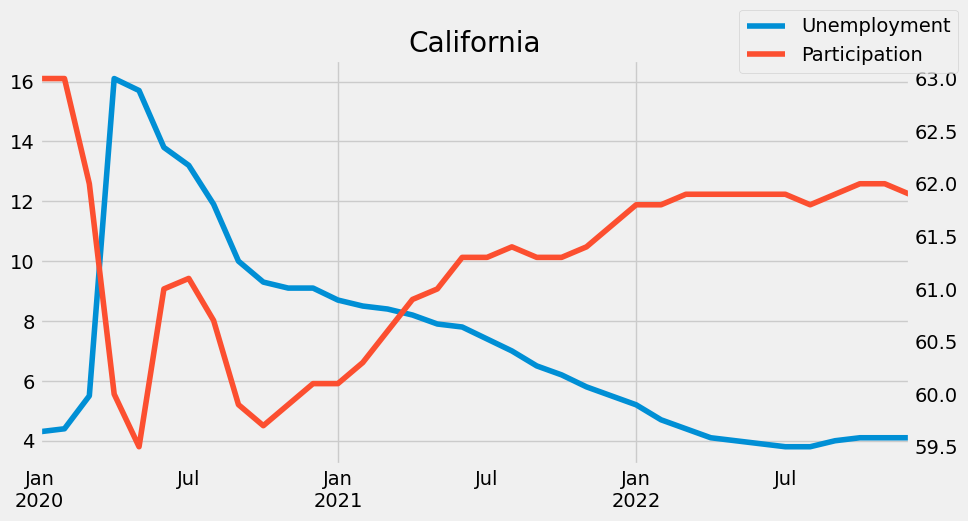

In [48]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states = uemp_states.asfreq('MS')
l1 = uemp_states.query('index >= 2020 and index < 2023')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2023')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()

-- Plot all

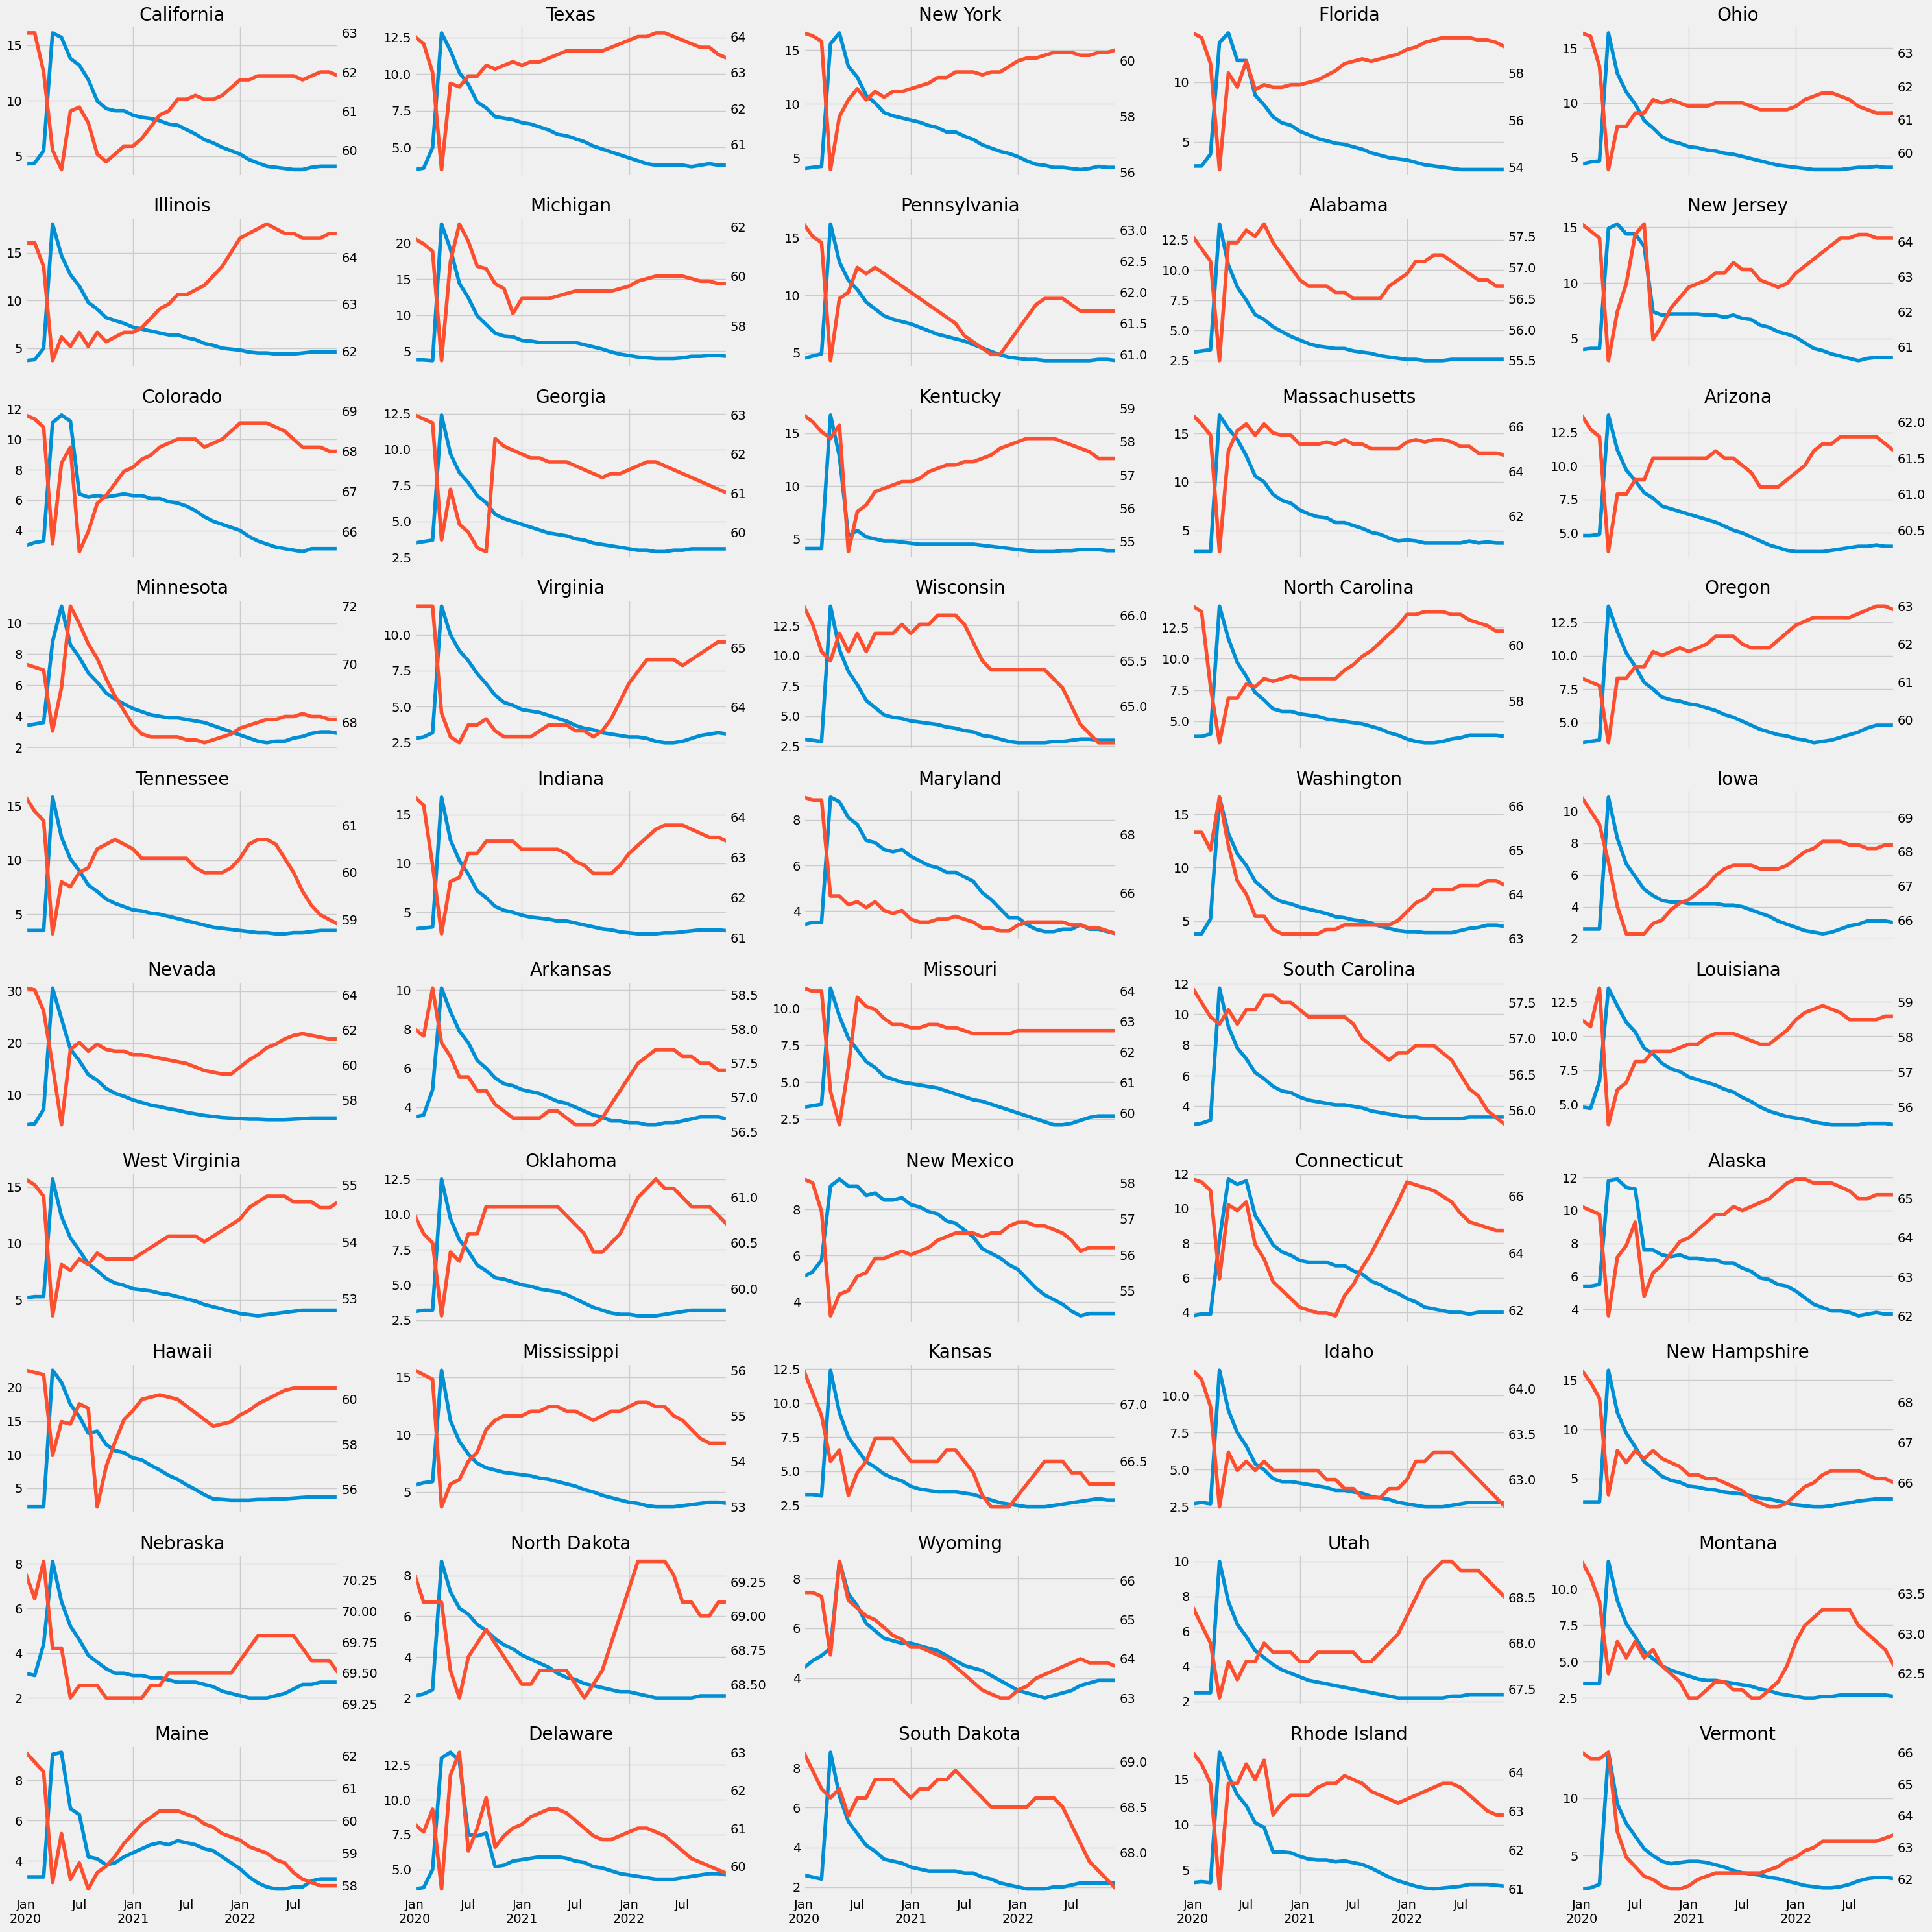

In [49]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2023')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2023')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

-- Dropdown

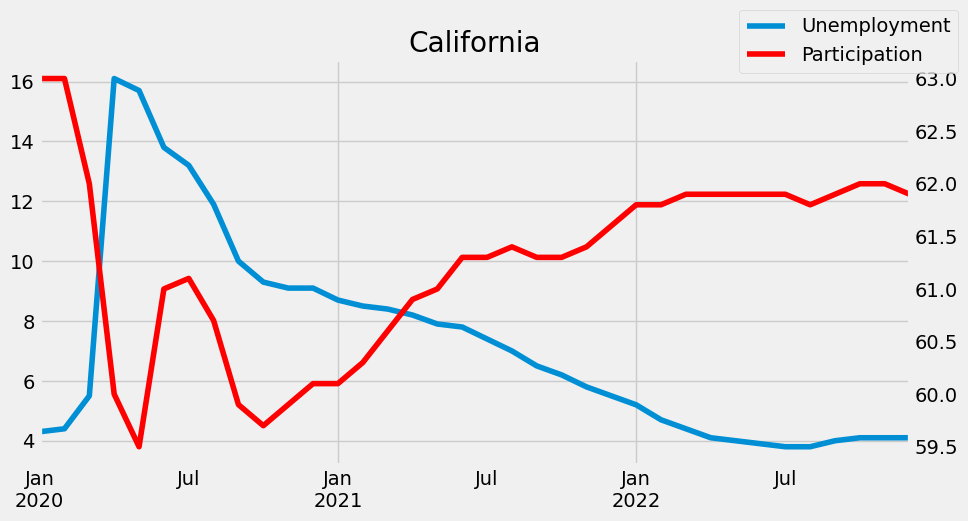

In [50]:
import ipywidgets as widgets
from IPython.display import display

uemp_states_sort = sorted(uemp_states.columns)

all_states = uemp_states.columns.tolist()

initial_state = 'California'

state_dropdown = widgets.Dropdown(
    options=all_states,
    value=initial_state,
    description='Select State:'
)

def update_plot(selected_state):
    fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
    ax2 = ax.twinx()
    uemp_states2 = uemp_states.asfreq('MS')
    l1 = uemp_states2.query('index >= 2020 and index < 2023')[selected_state] \
        .plot(ax=ax, label='Unemployment')
    l2 = part_states.dropna().query('index >= 2020 and index < 2023')[selected_state] \
        .plot(ax=ax2, label='Participation', color='red')  
    ax2.grid(False)
    ax.set_title(selected_state)
    fig.legend(labels=['Unemployment', 'Participation'])
    plt.show()

widgets.interactive(update_plot, selected_state=state_dropdown)